# ResNet实现
本篇notebook是对大名鼎鼎的ResNet(https://arxiv.org/pdf/1512.03385.pdf ）复现，开始干吧!
* 引用pytorch的基础包
* 加载CIFAR10数据集
* 定义残差块
* 定义网络整体结构


## 1 引用pytorch的基础包

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
DATASETS_PATH = '/home/qiangzibro/Projects/DATASETS/'

#使用gpu训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#定义超参数
number_epochs = 80
learning_rate = 0.001

#图像处理
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])
!ls

resnet100.ckpt	resnet200.ckpt	resnet300.ckpt	resnet400.ckpt	resnet50.ckpt
resnet150.ckpt	resnet250.ckpt	resnet350.ckpt	resnet450.ckpt	ResNet.ipynb


## 2加载CIFAR10数据集

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASETS_PATH,
                                             train=True,
                                             transform=transform,
                                             download=False)
test_dataset = torchvision.datasets.CIFAR10(root=DATASETS_PATH,
                                      train=False,
                                      transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100,
                                          shuffle=False)

## 3.定义残差块

In [3]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels,out_channels,kernel_size=3,
                     stride=stride,padding=1,bias=False)

class ResidualBlock(nn.Module):
    """
    定义一个残差块，注意输入数据格式是(N,C,H,W)
    args:
        in_channels 输入图像batch的特征通道数
        out_channels 输出图像batch的特征通道数
    """
    def __init__(self,in_channels,out_channels,stride=1,downsample=None):
        super(ResidualBlock,self).__init__()
        self.conv1 = conv3x3(in_channels,out_channels,stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels,out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

## 4.定义网络结构

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = conv3x3(3,self.in_channels)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        #最后是要完成一个分类的任务，所以做了全连接网络
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        """
        构建一个残差层，其中有`blocks`个残差块。如果输入通道和输出通道不一样，需要对输入进行下采样。也就是x+F(x)中第一项进行下采样，目的是维度匹配。
        args:
            block: 残差块
            out_channels: 输出通道
            blocks: 残差块的个数
            stride: 卷积步长
        """
        downsample = None
        if self.in_channels != out_channels or stride != 1:
            #两种情况都会造成x和F(x)的维度不一致
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride ),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample)) #因为尺寸变化，所以第一个残差块做了一个下采样
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
model = ResNet(ResidualBlock, [2,2,2]).to(device)

In [7]:
#为了测试
fake_image = torch.randn(3,3,32,32).to(device)
out = model(fake_image)
out.shape

torch.Size([3, 10])

## 5.开始训练
在完成网络的设计后，定义损失函数和优化方式，开始训练。归纳：一个常见的训练流程是
```
criterion = ...
optimizer = ...

for epoch in range(number_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def update_lr(optimizer, lr):
    for p in optimizer.param_groups:
        p['lr'] = lr

In [119]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [120]:
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(1,500):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
#                    .format(epoch+1, number_epochs, i+1, total_step, loss.item()))
    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    if epoch % 50 == 0:
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, number_epochs, i+1, total_step, loss.item()))
        torch.save(model.state_dict(), 'resnet{}.ckpt'.format(epoch))
        

Epoch [51/80], Step [500/500] Loss: 0.0605
Epoch [101/80], Step [500/500] Loss: 0.0444
Epoch [151/80], Step [500/500] Loss: 0.0247
Epoch [201/80], Step [500/500] Loss: 0.0260
Epoch [251/80], Step [500/500] Loss: 0.0234
Epoch [301/80], Step [500/500] Loss: 0.0172
Epoch [351/80], Step [500/500] Loss: 0.0288
Epoch [401/80], Step [500/500] Loss: 0.0595
Epoch [451/80], Step [500/500] Loss: 0.0657


## 6 模型的保存与测试
### 6.1 模型保存
只需要记住这样一个模板化的方式即可
* 保存torch.save(model.state_dict(), MODEL_PATH)

In [102]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

### 6.2 模型加载和评估
* 加载模型 test_model.load_state_dict(torch.load(MODEL_PATH))，注意这里的对象`test_model`要和模型对应的参数完全一致
* 测试


In [24]:
#加载模型
def evaluate(model, test_loader, MODEL_PATH = 'resnet100.ckpt'):
    test_model = model(ResidualBlock, [2,2,2]).to(device)
    test_model.load_state_dict(torch.load(MODEL_PATH))

    test_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = test_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the {} on the test images: {} %'.format(MODEL_PATH,
                                                         100 * correct / total))
        return correct / total


In [25]:
import os
for f in os.listdir():
    if f.split('.')[-1]=='ckpt':
        evaluate(ResNet, test_loader, f)

Accuracy of the resnet200.ckpt on the test images: 88.48 %
Accuracy of the resnet400.ckpt on the test images: 88.47 %
Accuracy of the resnet450.ckpt on the test images: 88.62 %
Accuracy of the resnet350.ckpt on the test images: 88.78 %
Accuracy of the resnet150.ckpt on the test images: 88.46 %
Accuracy of the resnet50.ckpt on the test images: 88.57 %
Accuracy of the resnet300.ckpt on the test images: 88.28 %
Accuracy of the resnet250.ckpt on the test images: 88.15 %
Accuracy of the resnet100.ckpt on the test images: 88.48 %


# 7 来加载一个模型看看算法效果

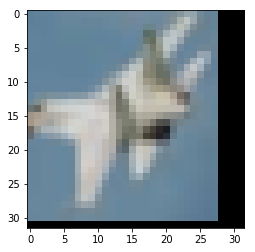

真实物体： airplane 预测物体： airplane


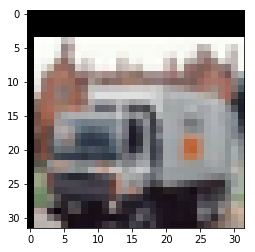

真实物体： truck 预测物体： truck


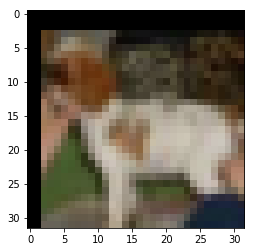

真实物体： dog 预测物体： dog


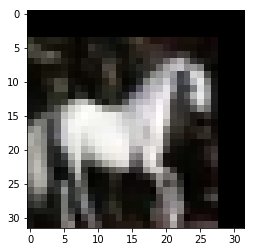

真实物体： horse 预测物体： horse


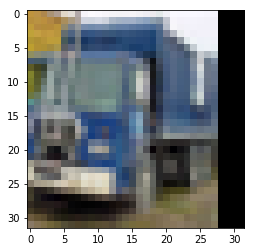

真实物体： truck 预测物体： truck


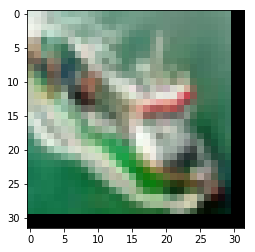

真实物体： ship 预测物体： ship


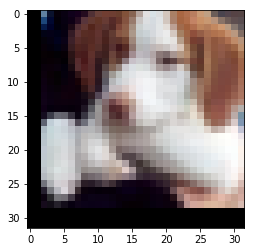

真实物体： dog 预测物体： dog


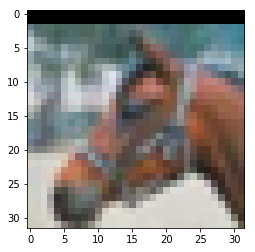

真实物体： horse 预测物体： horse


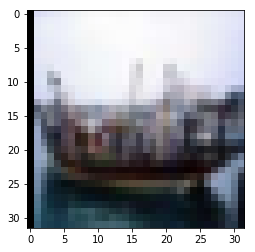

真实物体： ship 预测物体： ship


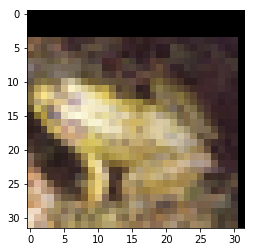

真实物体： frog 预测物体： frog


In [20]:
import matplotlib.pyplot as plt
MODEL_PATH='./resnet100.ckpt'
test_model = ResNet(ResidualBlock, [2,2,2]).to(device)
test_model.load_state_dict(torch.load(MODEL_PATH))
classes = test_dataset.classes #数据集给的
test_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = test_model(images)
        _, predicted = torch.max(outputs.data, 1)
        for index in range(10,20):
            image = images[index].permute(1,2,0).cpu().numpy()
            label_gt = classes[labels[index]]
            label_pre= classes[predicted[index]]
            plt.imshow(image)
            plt.show()
            print("真实物体：",label_gt, "预测物体：",label_pre)
        break